In [1]:
import sys
sys.path.append("..")

In [2]:
# import "aataset" (is in upper folder)
import dataset
import models
import config
from torch import nn
# import summary
import torch
from torchsummary import summary

/home/admin/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-21 13:26:45.905167: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-21 13:26:45.952185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 13:26:47.272869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorR

In [3]:
# get a sample from the dataset
dataloader = dataset.get_dataloader(batch_size=1, shuffle=False, num_workers=0)
sample = next(iter(dataloader))
samlpe = next(iter(dataloader))
sample = next(iter(dataloader))
spectrogram, caption = next(iter(dataloader))
spectrogram = spectrogram.to(config.DEVICE)

In [4]:
print(spectrogram.shape)

torch.Size([1, 1, 513, 431])


In [5]:
# run spectrogram through vae encoder
vae = models.VAE()

encodings_real = vae.encode(spectrogram)
encodings_real = encodings_real.latent_dist.mode()
# print shape
print(encodings_real.shape)

torch.Size([1, 8, 128, 107])


(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        3.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00,
        4.00000e+00, 4.00000e+00, 4.00000e+00, 4.00000e+00, 7.00000e+00,
        5.00000e+00, 6.00000e+00, 4.00000e+00, 9.00000e+00, 9.00000e+00,
        1.20000e+01, 2.40000e+01, 3.50000e+01, 4.60000e+01, 6.20000e+01,
        1.31000e+02, 2.52000e+02, 5.36000e+02, 1.53400e+03, 1.00875e+05,
        4.49500e+03, 8.33000e+02, 2.84000e+02, 1.45000e+02, 8.60000e+01,
        4.40000e+01, 2.70000e+01, 2.30000e+01, 1.50000e+01, 5.00000e+00,
        6.00000e+00, 5.00000e+00, 8.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 0.00

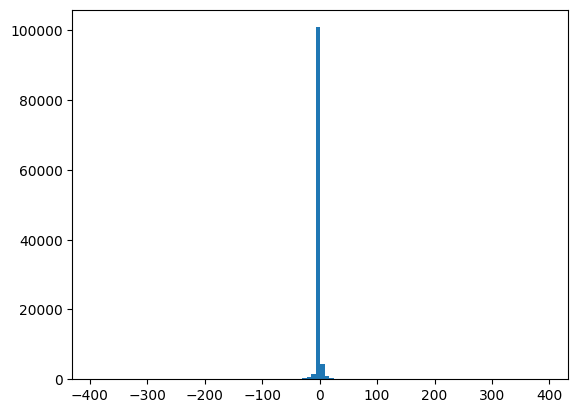

In [6]:
import matplotlib.pyplot as plt

plt.hist(encodings_real.flatten().cpu().detach().numpy(), bins=100)


In [7]:
# Create the generator
num_workers = torch.cuda.device_count()
netG = models.Generator(num_workers, channel_multiplier=3)
netG = netG.to(config.DEVICE)

# Handle multi-GPU if desired
if num_workers > 1:
    netG = nn.DataParallel(netG, list(range(num_workers)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(models._weights_init)

# apply the model to the fixed noise
noise = torch.randn(
    1, config.GENERATOR_INPUT_SIZE, 1, 1, device=config.DEVICE)
fake = netG(noise)
fake = fake.cpu().detach()
# print the shape
print(fake.shape)

torch.Size([1, 8, 128, 107])


(array([2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00, 8.0000e+00,
        3.0000e+00, 6.0000e+00, 1.0000e+01, 1.1000e+01, 1.4000e+01,
        1.7000e+01, 2.5000e+01, 3.5000e+01, 3.4000e+01, 3.7000e+01,
        6.8000e+01, 5.6000e+01, 6.7000e+01, 8.6000e+01, 8.1000e+01,
        1.2200e+02, 1.5800e+02, 1.7300e+02, 1.8100e+02, 2.2500e+02,
        3.0400e+02, 3.4100e+02, 3.7800e+02, 4.7300e+02, 4.8900e+02,
        5.8300e+02, 6.6800e+02, 7.4800e+02, 8.1200e+02, 9.7000e+02,
        1.0980e+03, 1.1770e+03, 1.3440e+03, 1.4490e+03, 1.6560e+03,
        1.7790e+03, 1.9240e+03, 2.1000e+03, 2.2630e+03, 2.4050e+03,
        2.4550e+03, 5.7585e+04, 2.4050e+03, 2.3600e+03, 2.1190e+03,
        1.9950e+03, 1.8420e+03, 1.6990e+03, 1.5220e+03, 1.4050e+03,
        1.2740e+03, 1.0510e+03, 1.0140e+03, 8.7500e+02, 7.7800e+02,
        7.1500e+02, 6.1200e+02, 5.0300e+02, 4.4100e+02, 3.9700e+02,
        3.5800e+02, 3.0100e+02, 2.2900e+02, 2.01

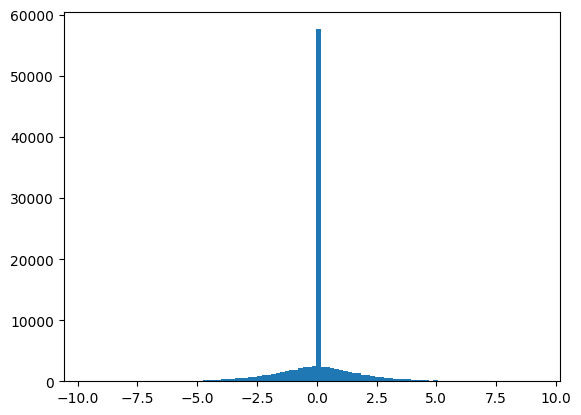

In [8]:
# show histogram of values of fake
plt.hist(fake.flatten().cpu().detach().numpy(), bins=100)


In [6]:
# now, the summary of the netd
# Create the Discriminator
netD = models.Discriminator(ngpu).to(config.DEVICE)

# Handle multi-GPU if desired
if (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(models._weights_init)

# Print the model
summary(netD, (8, 128, 107), 1)
print(f"Number of trainable parameters: {sum(p.numel() for p in netD.parameters() if p.requires_grad)}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 64, 54]           4,608
       BatchNorm2d-2            [1, 64, 64, 54]             128
         LeakyReLU-3            [1, 64, 64, 54]               0
            Conv2d-4           [1, 128, 32, 27]          73,728
       BatchNorm2d-5           [1, 128, 32, 27]             256
         LeakyReLU-6           [1, 128, 32, 27]               0
            Conv2d-7           [1, 256, 16, 14]         294,912
       BatchNorm2d-8           [1, 256, 16, 14]             512
         LeakyReLU-9           [1, 256, 16, 14]               0
           Conv2d-10               [1, 1, 8, 7]           2,304
          Sigmoid-11               [1, 1, 8, 7]               0
          Flatten-12                    [1, 56]               0
           Linear-13                     [1, 1]              57
          Sigmoid-14                   

In [7]:
# run the real and fake data through the discriminator
real_result = netD(encodings_real)
fake_result = netD(fake)

# print the results
print(f"Real result: {real_result}")
print(f"Fake result: {fake_result}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x14 and 56x1)